#### PREVISÃO DE DETECÇÃO DE FRAUDES EM TRANSAÇÕES FINANCEIRAS UTILIZANDO INTELIGÊNCIA ARTIFICIAL

In [1]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import locale
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings

locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

sns.set_theme(style= 'darkgrid', palette='tab20c')
warnings.filterwarnings("ignore")

C:\Users\jessicaassis\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


#### Processamento e Tratamento de Dados

In [2]:
# Lendo os dados e mostrando as 5 primeiras linhas
df = pd.read_csv(r'C:\Users\jessicaassis\OneDrive - KPMG\Desktop\Jessica\Pós_PUC\Projeto Integrado\archive (2)\bs140513_032310.csv')
df.head(5)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


In [3]:
# Tamanho do dataset
df.shape

(594643, 10)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


In [5]:
# Informações descritivas
df.describe().T

,count,mean,std,min,25%,50%,75%,max
step,594643.0,94.986827,51.053632,0.0,52.00,97.0,139.00,179.00
amount,594643.0,37.890135,111.402831,0.0,13.74,26.9,42.54,8329.96
fraud,594643.0,0.012108,0.109369,0.0,0.00,0.0,0.00,1.00


In [6]:
df.describe(include='object').T

,count,unique,top,freq
customer,594643,4112,'C1978250683',265
age,594643,8,'2',187310
gender,594643,4,'F',324565
zipcodeOri,594643,1,'28007',594643
merchant,594643,50,'M1823072687',299693
zipMerchant,594643,1,'28007',594643
category,594643,15,'es_transportation',505119


In [7]:
# Removendo colunas que possuem um unico valor
df= df.drop(columns= ['zipcodeOri', 'zipMerchant'])

# Removendo as aspas dos dados 
df['age'] = df['age'].str.replace("'", "").astype(str)
df['gender'] = df['gender'].str.replace("'", "").astype(str)
df['category'] = df['category'].str.replace("'", "").astype(str)
df['customer'] = df['customer'].str.replace("'", "").astype(str)
df['merchant'] = df['merchant'].str.replace("'", "").astype(str)

# Substituindo "U" da coluna Idade
df['age'] = df['age'].str.replace("U", "7").astype(int)

# Removendo o 'es' da coluna Categoria
df['category'] = df['category'].str.replace("es_", "").astype(str)

In [8]:
df.head()

,step,customer,age,gender,merchant,category,amount,fraud
0,0,C1093826151,4,M,M348934600,transportation,4.55,0
1,0,C352968107,2,M,M348934600,transportation,39.68,0
2,0,C2054744914,4,F,M1823072687,transportation,26.89,0
3,0,C1760612790,3,M,M348934600,transportation,17.25,0
4,0,C757503768,5,M,M348934600,transportation,35.72,0


In [9]:
df.age.value_counts()

2    187310
3    147131
4    109025
5     62642
1     58131
6     26774
0      2452
7      1178
Name: age, dtype: int64

In [10]:
df.category.value_counts()

transportation        505119
food                   26254
health                 16133
wellnessandbeauty      15086
fashion                 6454
barsandrestaurants      6373
hyper                   6098
sportsandtoys           4002
tech                    2370
home                    1986
hotelservices           1744
otherservices            912
contents                 885
travel                   728
leisure                  499
Name: category, dtype: int64

In [11]:
len(df.category.value_counts())

15

In [12]:
# Verificando a quantidade de dados de fraude 
df['fraud'].value_counts()

0    587443
1      7200
Name: fraud, dtype: int64

#### Análise, Exploração e Vizualização dos Dados

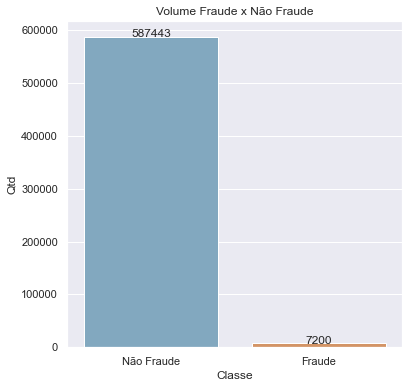

Quantidade de transações não fraudulentas: 587443
Quantidade de transações fraudulentas: 7200
Porcentagem de fraude em relação ao total de transações: 1.21%


In [13]:
# Volume por fraude e não fraude
plt.figure(figsize=(6, 6))
g= sns.countplot(x= 'fraud', data=df, palette= ['#78ABC9', '#E59154'])
plt.title("Volume Fraude x Não Fraude")
plt.xlabel('Classe')
g.set_xticklabels(['Não Fraude', 'Fraude'])
plt.ylabel('Qtd')
for p in g.patches:
    g.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
               ha='center', va='baseline')
plt.show()
print('Quantidade de transações não fraudulentas: {}'.format(df['fraud'].value_counts()[0]))
print('Quantidade de transações fraudulentas: {}'.format(df['fraud'].value_counts()[1]))
print('Porcentagem de fraude em relação ao total de transações: {}%'.format(round((df['fraud'].value_counts()[1]/df['fraud'].count())*100, 2)))

In [14]:
# Separando os dados em fraude e não fraude
df_fraud = df[df['fraud'] == 1]
df_notfraud = df[df['fraud'] == 0]

In [15]:
# Contagens de fraude e não fraude por categoria
fraud_counts = df_fraud['category'].value_counts().reset_index()
fraud_counts.columns = ['category', 'Fraude']
not_fraud_counts = df_notfraud['category'].value_counts().reset_index()
not_fraud_counts.columns = ['category', 'Não Fraude']

In [16]:
# Combinando os dataframes
group_df = pd.merge(fraud_counts, not_fraud_counts, on='category', how='outer')

# Renomeando coluna
group_df.rename(columns={'category': 'Categoria'}, inplace=True)

# Preenchendo valores ausentes com 0
group_df = group_df.fillna(0)

# Adicionando coluna Total por Categoria/ Percentual de fraudes em relação ao total por categoria
group_df['Total'] = group_df['Fraude'] + group_df['Não Fraude']
group_df['% Fraude'] = round((group_df['Fraude'] / group_df['Total']) * 100, 2)

# Ordenando o DataFrame pelo valor de Fraude em ordem decrescente
group_df = group_df.sort_values(by='Fraude', ascending=False)

In [17]:
group_df

,Categoria,Fraude,Não Fraude,Total,% Fraude
0,sportsandtoys,1982.0,2020,4002.0,49.53
1,health,1696.0,14437,16133.0,10.51
2,wellnessandbeauty,718.0,14368,15086.0,4.76
3,travel,578.0,150,728.0,79.40
4,hotelservices,548.0,1196,1744.0,31.42
5,leisure,474.0,25,499.0,94.99
6,home,302.0,1684,1986.0,15.21
7,hyper,280.0,5818,6098.0,4.59
8,otherservices,228.0,684,912.0,25.00
9,tech,158.0,2212,2370.0,6.67


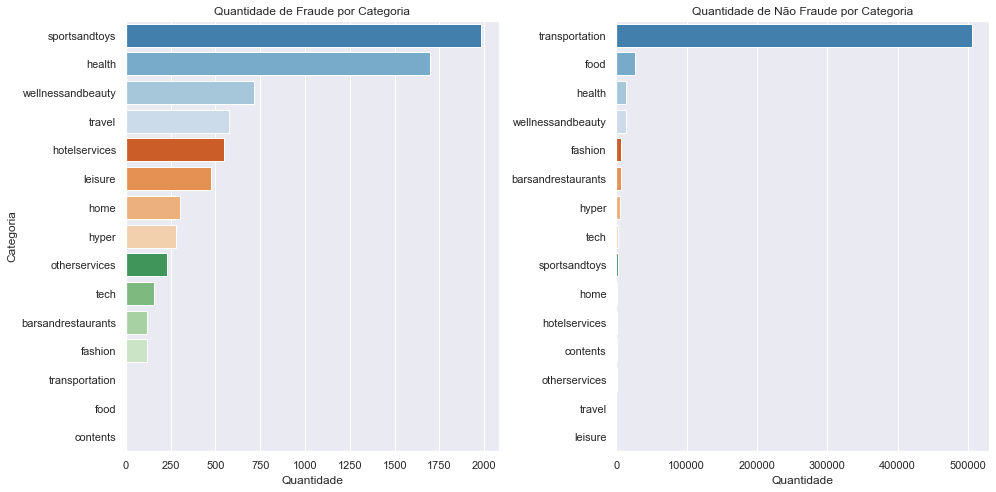

In [18]:
#Distribuição por Categoria
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Primeiro subplot
sns.barplot(data=group_df, x='Fraude', y='Categoria', ax=axes[0])
axes[0].set_xlabel('Quantidade')
axes[0].set_ylabel('Categoria')
axes[0].set_title('Quantidade de Fraude por Categoria')

# Segundo subplot 
sns.barplot(data=group_df.sort_values(by='Não Fraude', ascending=False), x='Não Fraude', y='Categoria', ax=axes[1])
axes[1].set_xlabel('Quantidade')
axes[1].set_ylabel('')
axes[1].set_title('Quantidade de Não Fraude por Categoria')

plt.tight_layout()

plt.show()


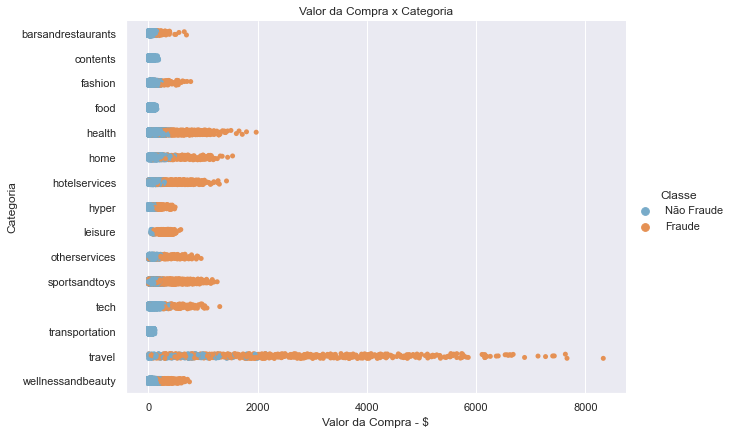

In [19]:
#Compras por categoria
class_labels = {'0': 'Não Fraude', '1': 'Fraude'}

g= sns.catplot(data=df.sort_values(by='category'), y='category', x='amount', hue='fraud', height=6, aspect=1.5, palette= ['#78ABC9', '#E59154'])
g._legend.set_title('Classe') 
sns.move_legend(g, "upper center", bbox_to_anchor=(1, .6))
plt.title("Valor da Compra x Categoria")
plt.ylabel('Categoria')
plt.xlabel('Valor da Compra - $')
# Renomeando os rótulos da legenda
for t, l in zip(g._legend.texts, class_labels.values()):
    t.set_text(l)
plt.show()

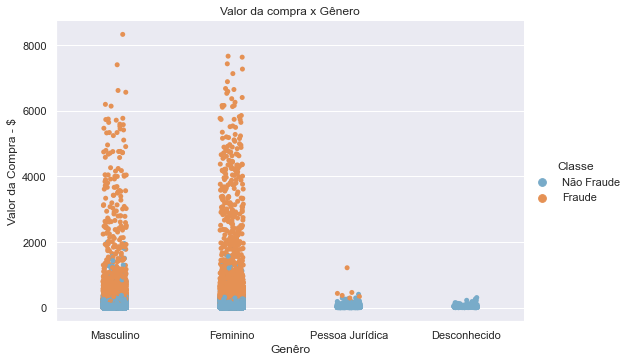

In [20]:
#Compras por Genero 
class_labels = {'0': 'Não Fraude', '1': 'Fraude'}
g= sns.catplot(data=df, x='gender', y='amount', hue='fraud', height=5, aspect=1.5, palette= ['#78ABC9', '#E59154'])
g._legend.set_title('Classe') 
sns.move_legend(g, "upper center", bbox_to_anchor=(1, .6))
plt.title("Valor da compra x Gênero")
plt.ylabel('Valor da Compra - $')
plt.xlabel('Genêro')
g.set_xticklabels(['Masculino', 'Feminino', 'Pessoa Jurídica', 'Desconhecido'])
# Renomeando os rótulos da legenda
for t, l in zip(g._legend.texts, class_labels.values()):
    t.set_text(l)
plt.show()

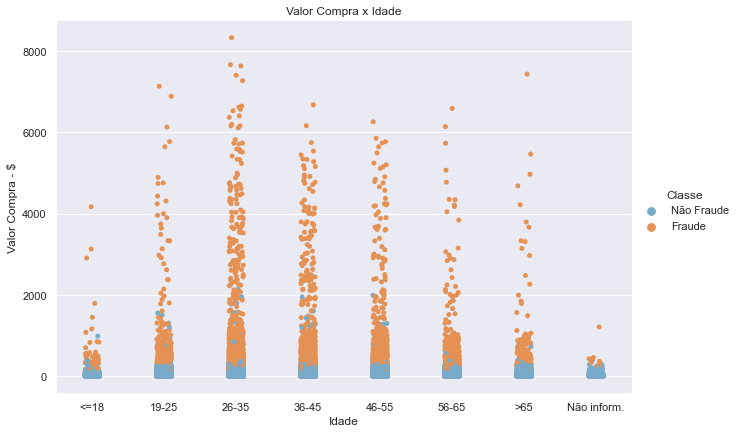

In [21]:
#Compras por Idade 
class_labels = {'0': 'Não Fraude', '1': 'Fraude'}
g= sns.catplot(data=df, x='age', y='amount', hue='fraud', height=6, aspect=1.5, palette= ['#78ABC9', '#E59154'])
g._legend.set_title('Classe') 
sns.move_legend(g, "upper center", bbox_to_anchor=(1, .6))
plt.title("Valor Compra x Idade")
plt.ylabel('Valor Compra - $')
plt.xlabel('Idade')
g.set_xticklabels(['<=18', '19-25', '26-35', '36-45', '46-55', '56-65', '>65', 'Não inform.'])
# Renomeando os rótulos da legenda
for t, l in zip(g._legend.texts, class_labels.values()):
    t.set_text(l)
plt.show()

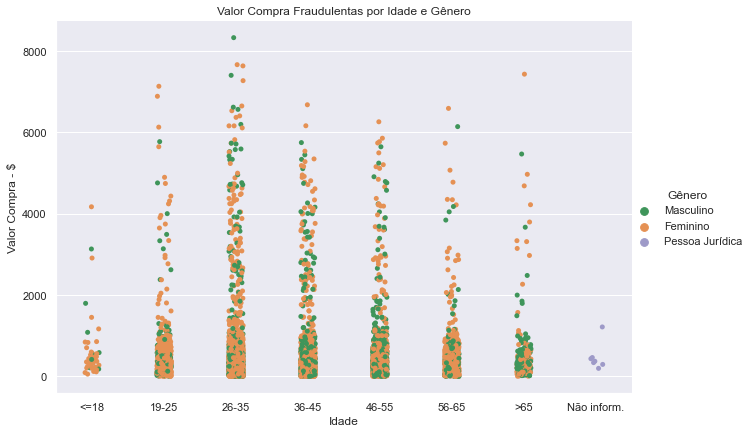

In [22]:
#Valor Compra Fraudulenta por Idade e Genero
gender_labels = {'M': 'Masculino', 'F': 'Feminino', 'E': 'Pessoa Jurídica'}
g= sns.catplot(data=df_fraud, x='age', y='amount', hue='gender', height= 6, aspect=1.5, palette= ['#3f955a','#E59154', '#9e9ac8'])
g.set_xticklabels(['<=18', '19-25', '26-35', '36-45', '46-55', '56-65', '>65', 'Não inform.'])
g._legend.set_title('Gênero') 
sns.move_legend(g, "upper center", bbox_to_anchor=(1, .6))

plt.title("Valor Compra Fraudulentas por Idade e Gênero")
plt.ylabel('Valor Compra - $')
plt.xlabel('Idade')
# Renomeando os rótulos da legenda
for t, l in zip(g._legend.texts, gender_labels.values()):
    t.set_text(l)
plt.show()

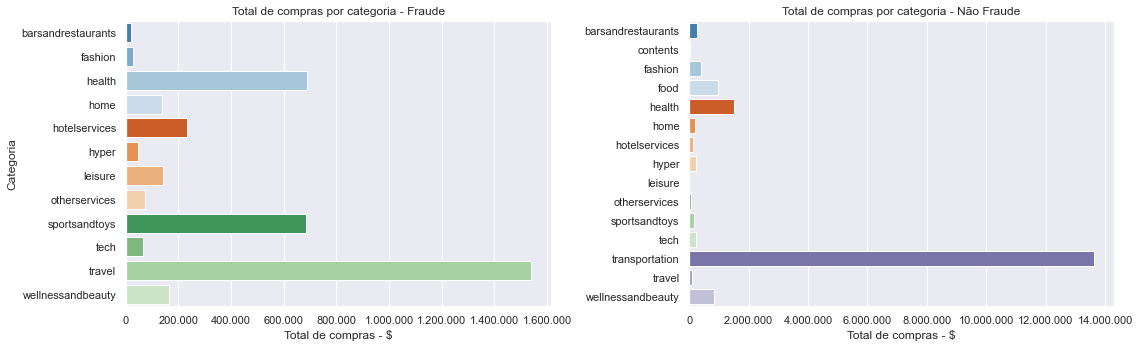

In [23]:
#Distribuição da Soma total de compras por Categoria

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Primeiro subplot
sns.barplot(data=df_fraud.sort_values(by='category'), x='amount', y='category', estimator=sum, ci= None, ax=axes[0])
axes[0].set_ylabel('Categoria')
axes[0].set_xlabel('Total de compras - $')
axes[0].set_title('Total de compras por categoria - Fraude')
axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: locale.format_string('%.0f', x, grouping=True)))

# Segundo subplot 
sns.barplot(data=df_notfraud.sort_values(by='category'), x='amount', y='category', estimator=sum, ci= None, ax=axes[1])
axes[1].set_xlabel('Total de compras - $')
axes[1].set_ylabel('')
axes[1].set_title('Total de compras por categoria - Não Fraude')
axes[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: locale.format_string('%.0f', x, grouping=True)))

plt.tight_layout()

plt.show()

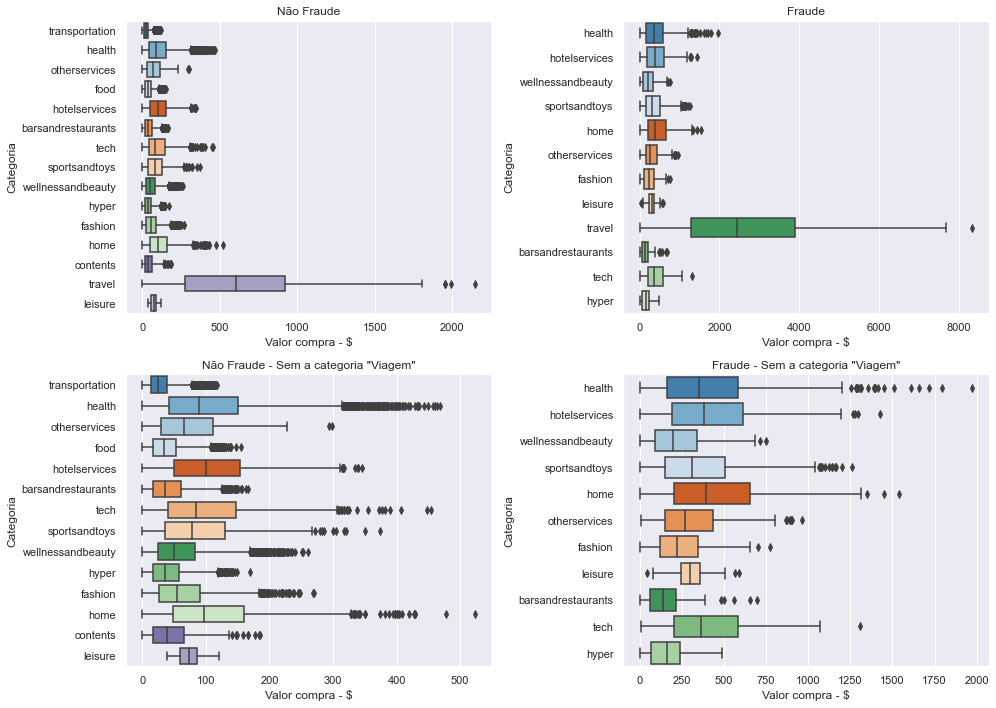

In [24]:
#Boxplot categoria
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Primeiro subplot
sns.boxplot(y=df_notfraud['category'] ,x=df_notfraud['amount'],  ax=axes[0, 0])
axes[0, 0].set_ylabel('Categoria')
axes[0, 0].set_xlabel('Valor compra - $')
axes[0, 0].set_title('Não Fraude')

# Segundo subplot 
sns.boxplot(y=df_fraud['category'] ,x=df_fraud['amount'],   ax=axes[0, 1])
axes[0, 1].set_ylabel('Categoria')
axes[0, 1].set_xlabel('Valor compra - $')
axes[0, 1].set_title('Fraude')

# Terceiro subplot
sns.boxplot(y=df_notfraud[df_notfraud['category'] != 'travel']['category'] ,x=df_notfraud[df_notfraud['category'] != 'travel']['amount'],  ax=axes[1, 0])
axes[1, 0].set_ylabel('Categoria')
axes[1, 0].set_xlabel('Valor compra - $')
axes[1, 0].set_title('Não Fraude - Sem a categoria "Viagem"')

# Quarto subplot 
sns.boxplot(y=df_fraud[df_fraud['category'] != 'travel']['category'] ,x=df_fraud[df_fraud['category'] != 'travel']['amount'],   ax=axes[1, 1])
axes[1, 1].set_ylabel('Categoria')
axes[1, 1].set_xlabel('Valor compra - $')
axes[1, 1].set_title('Fraude - Sem a categoria "Viagem"')

plt.tight_layout()
plt.show()


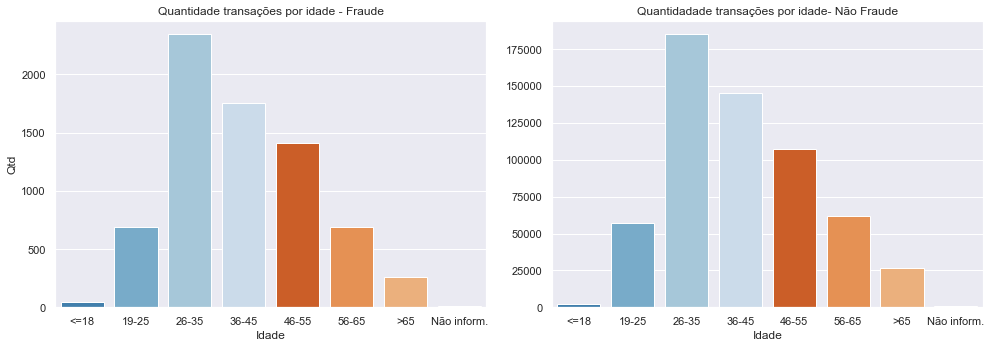

In [25]:
#Distribuição da quantidade de transações por Idade

new_labels = ['<=18', '19-25', '26-35', '36-45', '46-55', '56-65', '>65', 'Não inform.']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Primeiro subplot
sns.countplot(data=df_fraud, x='age', order= sorted(df_fraud['age'].unique()), ax=axes[0])
axes[0].set_xlabel('Idade')
axes[0].set_ylabel('Qtd')
axes[0].set_title('Quantidade transações por idade - Fraude')
axes[0].set_xticklabels(new_labels)

# Segundo subplot 
sns.countplot(data=df_notfraud, x='age',  order= sorted(df_fraud['age'].unique()), ax=axes[1])
axes[1].set_xlabel('Idade')
axes[1].set_ylabel('')
axes[1].set_title('Quantidadade transações por idade- Não Fraude')
axes[1].set_xticklabels(new_labels)


plt.tight_layout()
plt.show()

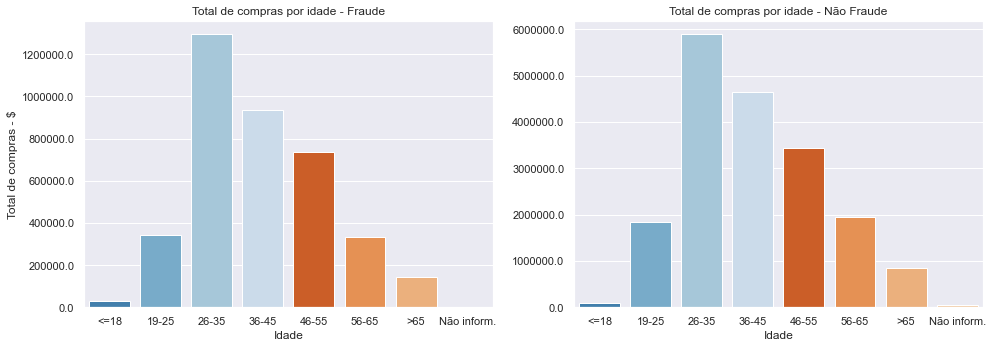

In [26]:
#Distribuição da Soma  total de compras por Idade

new_labels = ['<=18', '19-25', '26-35', '36-45', '46-55', '56-65', '>65', 'Não inform.']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Primeiro subplot
sns.barplot(data=df_fraud, x='age', y='amount', estimator=sum, ci= None, ax=axes[0])
axes[0].set_xlabel('Idade')
axes[0].set_ylabel('Total de compras - $')
axes[0].set_title('Total de compras por idade - Fraude')
axes[0].set_xticklabels(new_labels)
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: round(x, 2))) 

# Segundo subplot 
sns.barplot(data=df_notfraud, x='age', y='amount', estimator=sum, ci= None, ax=axes[1])
axes[1].set_xlabel('Idade')
axes[1].set_ylabel('')
axes[1].set_title('Total de compras por idade - Não Fraude')
axes[1].set_xticklabels(new_labels)
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: round(x, 2)))

plt.tight_layout()

plt.show()

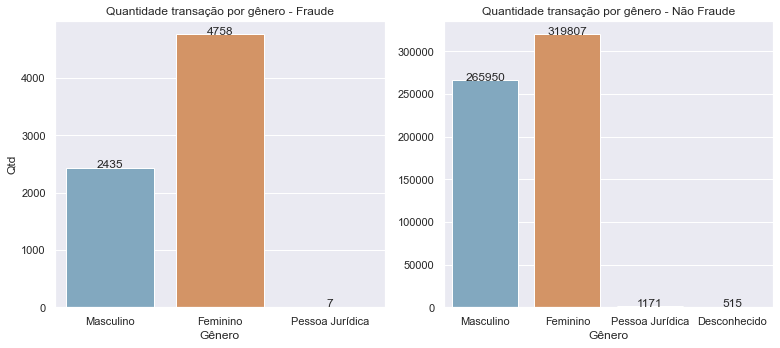

In [27]:
#Distribuição de Frequencia de Transações por Gênero

fig, axes = plt.subplots(1, 2, figsize=(11, 5))

# Primeiro subplot
sns.countplot(data=df_fraud, x='gender', ax=axes[0], palette= ['#78ABC9', '#E59154','#3F955A'])
axes[0].set_xlabel('Gênero')
axes[0].set_ylabel('Qtd')
axes[0].set_title('Quantidade transação por gênero - Fraude')
axes[0].set_xticklabels(['Masculino', 'Feminino', 'Pessoa Jurídica'])

for p in axes[0].patches:
    axes[0].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')

# Segundo subplot 
sns.countplot(data=df_notfraud, x='gender', ax=axes[1], palette= ['#78ABC9', '#E59154','#3F955A', '#9e9ac8'])
axes[1].set_xlabel('Gênero')
axes[1].set_ylabel('')
axes[1].set_title('Quantidade transação por gênero - Não Fraude')
axes[1].set_xticklabels(['Masculino', 'Feminino', 'Pessoa Jurídica', 'Desconhecido'])

for p in axes[1].patches:
    axes[1].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')

plt.tight_layout()

plt.show()

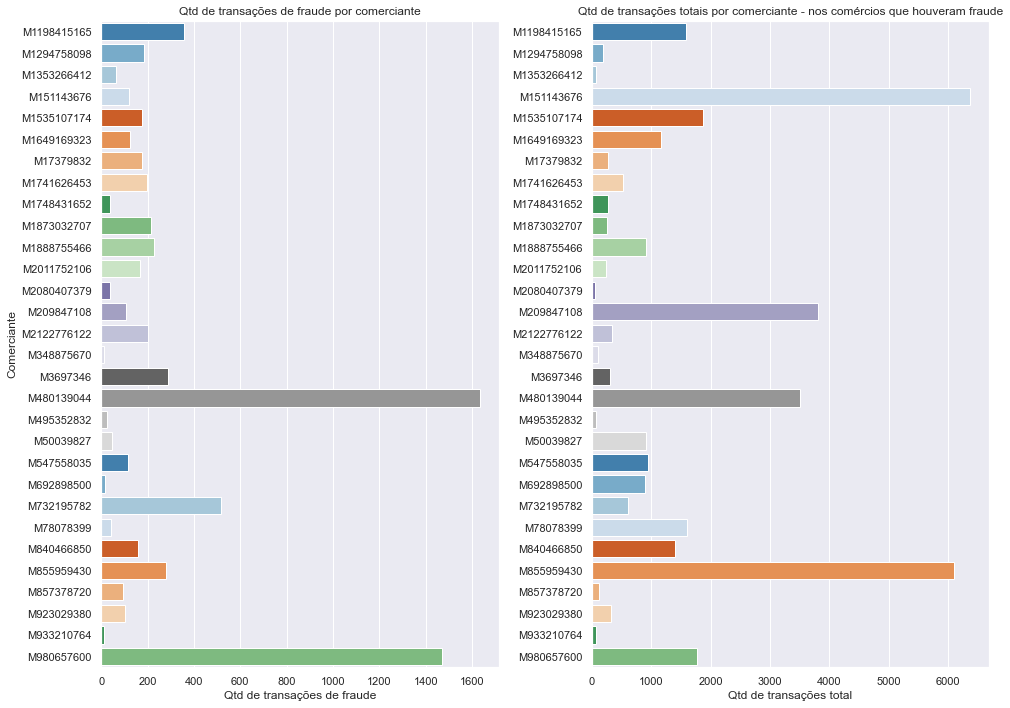

In [28]:
#Frequencia de transação por Comerciante
filtered_df = df[df['merchant'].isin(df_fraud['merchant'])]

fig, axes = plt.subplots(1, 2, figsize=(14, 10))

# Primeiro subplot
sns.countplot(data=df_fraud.sort_values(by='merchant'), y='merchant', palette= 'tab20c', ax=axes[0])
axes[0].set_xlabel('Qtd de transações de fraude')
axes[0].set_ylabel('Comerciante')
axes[0].set_title('Qtd de transações de fraude por comerciante')


# Segundo subplot 
sns.countplot(data=filtered_df.sort_values(by='merchant'), y='merchant', ax=axes[1], palette= 'tab20c')
axes[1].set_xlabel('Qtd de transações total')
axes[1].set_ylabel('')
axes[1].set_title('Qtd de transações totais por comerciante - nos comércios que houveram fraude')


plt.tight_layout()

plt.show()

In [29]:
df_fraud.merchant.value_counts()

M480139044     1634
M980657600     1472
M732195782      518
M1198415165     358
M3697346        290
M855959430      280
M1888755466     228
M1873032707     216
M2122776122     200
M1741626453     196
M1294758098     184
M17379832       178
M1535107174     174
M2011752106     166
M840466850      158
M1649169323     124
M151143676      120
M547558035      116
M209847108      106
M923029380      102
M857378720       92
M1353266412      64
M50039827        46
M78078399        44
M1748431652      36
M2080407379      36
M495352832       24
M692898500       16
M933210764       12
M348875670       10
Name: merchant, dtype: int64

In [30]:
round(df_fraud.merchant[df_fraud.merchant == 'M480139044'].count()/ df_fraud.merchant.count()*100, 2)

22.69

In [31]:
round(df_fraud.merchant[df_fraud.merchant == 'M480139044'].count()/filtered_df.merchant[filtered_df.merchant == 'M480139044'].count()*100, 2)

46.58

#### Preparação dos Dados para os Modelos de Aprendizado de Máquina

In [32]:
df_lab_encoded= df.copy()

In [33]:
df_lab_encoded.dtypes

step          int64
customer     object
age           int32
gender       object
merchant     object
category     object
amount      float64
fraud         int64
dtype: object

In [34]:
# Rótulos para 'category', 'gender', 'merchant' e customer
label_encoder = LabelEncoder()

df_lab_encoded['category_encoded'] = label_encoder.fit_transform(df_lab_encoded['category'])
df_lab_encoded['gender_encoded'] = label_encoder.fit_transform(df_lab_encoded['gender'])
df_lab_encoded['merchant_encoded'] = label_encoder.fit_transform(df_lab_encoded['merchant'])
df_lab_encoded['customer_encoded'] = label_encoder.fit_transform(df_lab_encoded['customer'])

In [35]:
df_lab_encoded.drop(columns= ['category', 'merchant', 'gender', 'customer', 'step'], inplace=True)

In [36]:
df_lab_encoded = df_lab_encoded[['customer_encoded', 'age', 'gender_encoded', 'merchant_encoded', 'category_encoded', 'amount', 'fraud']]

In [37]:
df_lab_encoded.head(5)

,customer_encoded,age,gender_encoded,merchant_encoded,category_encoded,amount,fraud
0,210,4,2,30,12,4.55,0
1,2753,2,2,30,12,39.68,0
2,2285,4,1,18,12,26.89,0
3,1650,3,2,30,12,17.25,0
4,3585,5,2,30,12,35.72,0


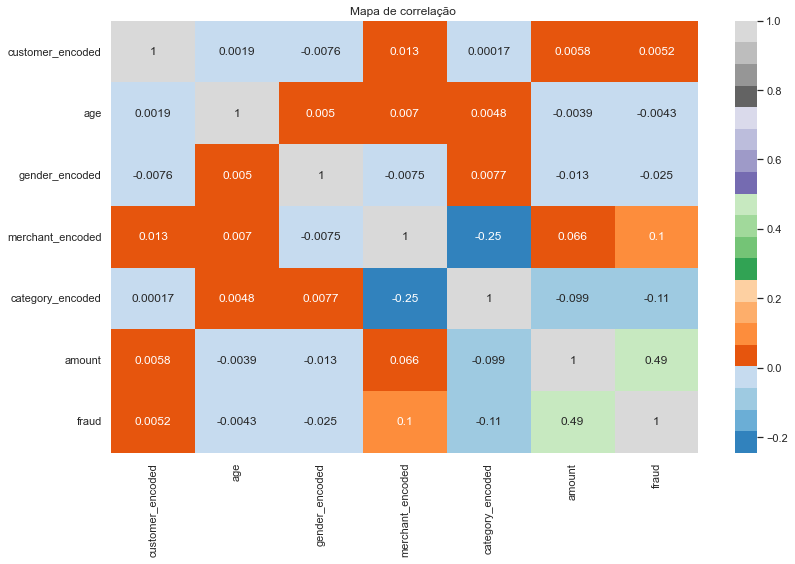

In [38]:
#Correlação entre variáveis
fig, ax=plt.subplots(figsize=(12, 8))
ax=sns.heatmap(df_lab_encoded.corr(), annot= True, cmap= 'tab20c')
ax.set_title('Mapa de correlação ')
fig.tight_layout()

In [39]:
#Separando os dados para usar a tecnica de desbalanceamento
X = df_lab_encoded.drop(['fraud'],axis=1)
y = df_lab_encoded['fraud']


#### Técnica SMOTE

In [40]:
#UTILIZANDO SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_res, y_res = smote.fit_resample(X, y)
y_res = pd.DataFrame(y_res)

In [41]:
y_res.value_counts()

fraud
0        587443
1        587443
dtype: int64

<b>Aplicação e Avaliação de Modelos de Aprendizado de Máquina</b>

<b>1° modelo - Random Forest Classifier (Com Smote) </b>

In [42]:
# Dividindo entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42,shuffle=True)

In [43]:
# Criando um modelo Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100, min_samples_split= 3, random_state=42)

# Treinando o modelo no conjunto de treinamento
rf_classifier.fit(X_train, y_train)

# Fazendo as previsão com o conjunto de teste
y_pred = rf_classifier.predict(X_test)

In [44]:
# Classification Report
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, digits=4))

# Acuracia
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred)))

#Área sobre a curva
print("AUC ROC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9982    0.9925    0.9953    117625
           1     0.9925    0.9982    0.9953    117353

    accuracy                         0.9953    234978
   macro avg     0.9953    0.9953    0.9953    234978
weighted avg     0.9953    0.9953    0.9953    234978

Acurácia: 0.9953

AUC ROC: 0.9953



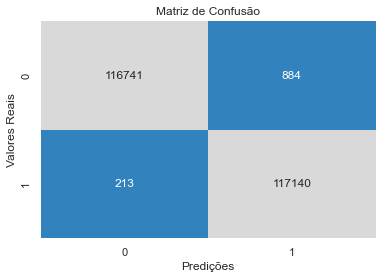

In [45]:
#Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="tab20c", cbar=False)
plt.xlabel('Predições')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão')

plt.show()

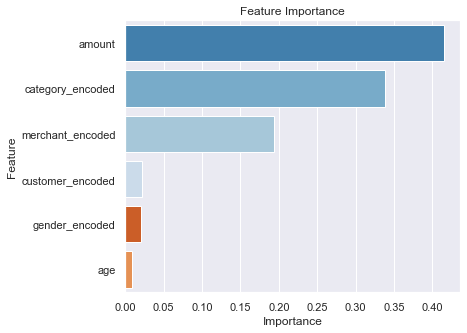

In [46]:
# Feature Importance
feature_importance = rf_classifier.feature_importances_
feature_names = list(X_train.columns) 
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending= False)

plt.figure(figsize=(6, 5))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [47]:
print(importance_df)

            Feature  Importance
5            amount    0.415109
4  category_encoded    0.338375
3  merchant_encoded    0.193775
0  customer_encoded    0.022391
2    gender_encoded    0.020894
1               age    0.009455


<b> 2° modelo - XGBoost (Com Smote) </b> 

In [48]:
# Dividindo entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42,shuffle=True)

In [49]:
# Criando um modelo XGboost
xgb_classifier = XGBClassifier(n_estimators= 100, learning_rate= 0.02, max_depth= 20, random_state=42)

# Treinando o modelo no conjunto de treinamento
xgb_classifier.fit(X_train, y_train)

# Fazendo previsões no conjunto de teste
y_pred = xgb_classifier.predict(X_test)

[17:17:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [50]:
# Classification Report
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, digits=4))

# Acuracia
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred)))

#Área sobre a curva
print("AUC ROC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9967    0.9916    0.9941    117625
           1     0.9917    0.9967    0.9942    117353

    accuracy                         0.9941    234978
   macro avg     0.9942    0.9942    0.9941    234978
weighted avg     0.9942    0.9941    0.9941    234978

Acurácia: 0.9941

AUC ROC: 0.9942



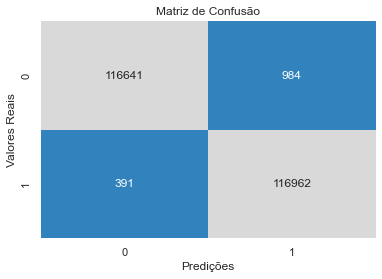

In [51]:
#Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="tab20c", cbar=False)
plt.xlabel('Predições')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão')

plt.show()

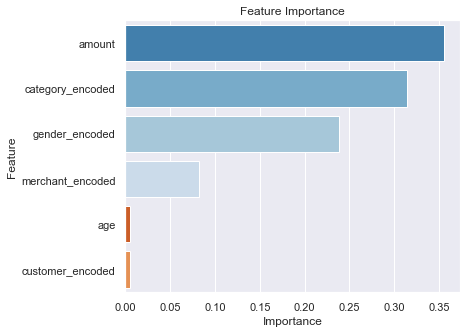

In [52]:
# Feature Importance
feature_importance = xgb_classifier.feature_importances_
feature_names = list(X_train.columns) 
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending= False)

plt.figure(figsize=(6, 5))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [53]:
print(importance_df)

            Feature  Importance
5            amount    0.355414
4  category_encoded    0.314473
2    gender_encoded    0.238246
3  merchant_encoded    0.082067
1               age    0.004914
0  customer_encoded    0.004885


#### Técnica Undersampling

In [54]:
# UNDERSAMPLING
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

X_resampled, y_resampled = undersampler.fit_resample(X, y)


In [55]:
y_resampled.value_counts()

0    7200
1    7200
Name: fraud, dtype: int64

<b>3° modelo - Random Forest Classifier (Com Undersampling)</b>

In [56]:
# Dividindo entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [57]:
# Criando um modelo Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100, min_samples_split= 3, random_state=42)

# Treinando o modelo no conjunto de treinamento
rf_classifier.fit(X_train, y_train)

# Fazendo as previsão com o conjunto de teste
y_pred = rf_classifier.predict(X_test)

In [58]:
# Classification Report
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, digits=4))

# Acuracia
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred)))

#Área sobre a curva
print("AUC ROC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9871    0.9615    0.9741      1429
           1     0.9630    0.9876    0.9752      1451

    accuracy                         0.9747      2880
   macro avg     0.9751    0.9746    0.9746      2880
weighted avg     0.9750    0.9747    0.9746      2880

Acurácia: 0.9747

AUC ROC: 0.9746



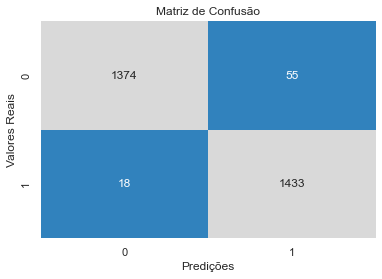

In [59]:
#Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="tab20c", cbar=False)
plt.xlabel('Predições')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão')

plt.show()

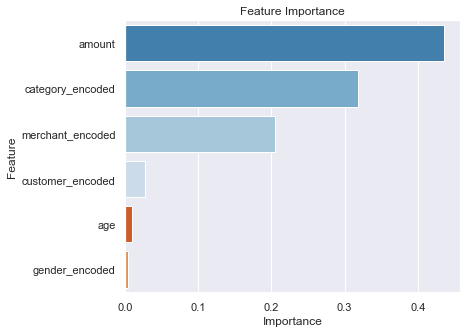

In [60]:
# Feature Importance
feature_importance = rf_classifier.feature_importances_
feature_names = list(X_train.columns) 
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending= False)

plt.figure(figsize=(6, 5))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [61]:
print(importance_df)

            Feature  Importance
5            amount    0.436027
4  category_encoded    0.318111
3  merchant_encoded    0.205321
0  customer_encoded    0.027092
1               age    0.009397
2    gender_encoded    0.004052


<b>4° modelo - XGBoost (Com Undersampling)</b>

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [63]:
# Criando um modelo XGboost
xgb_classifier = XGBClassifier(n_estimators= 100, learning_rate= 0.02, max_depth= 20, random_state=42)

# Treinando o modelo no conjunto de treinamento
xgb_classifier.fit(X_train, y_train)

# Fazendo previsões no conjunto de teste
y_pred = xgb_classifier.predict(X_test)

[17:19:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [64]:
# Classification Report
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, digits=4))

# Acuracia
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred)))

#Área sobre a curva
print("AUC ROC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9814    0.9622    0.9717      1429
           1     0.9635    0.9821    0.9727      1451

    accuracy                         0.9722      2880
   macro avg     0.9725    0.9721    0.9722      2880
weighted avg     0.9724    0.9722    0.9722      2880

Acurácia: 0.9722

AUC ROC: 0.9721



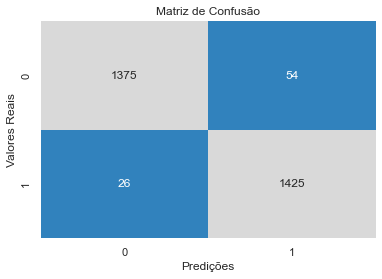

In [65]:
#Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="tab20c", cbar=False)
plt.xlabel('Predições')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão')

plt.show()

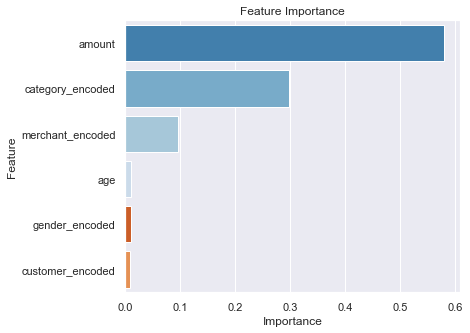

In [66]:
# Feature Importance
feature_importance = xgb_classifier.feature_importances_
feature_names = list(X_train.columns) 
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending= False)

plt.figure(figsize=(6, 5))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [67]:
print(importance_df)

            Feature  Importance
5            amount    0.579355
4  category_encoded    0.296810
3  merchant_encoded    0.095754
1               age    0.010092
2    gender_encoded    0.009639
0  customer_encoded    0.008351
